In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
from scipy import stats
from scipy.optimize import minimize, curve_fit
from scipy.special import erf # error function
from iminuit import Minuit

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
data = pd.read_csv('../../notebooks/data/ex9_data.csv.gz')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 604 entries, 0 to 603
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       604 non-null    float64
dtypes: float64(1)
memory usage: 9.4 KB


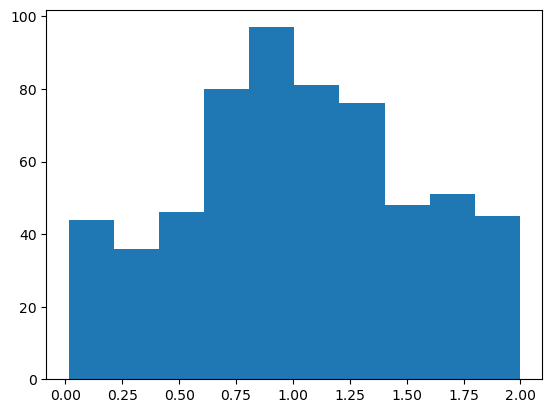

In [3]:
plt.hist(data['x'], bins=10)
plt.show()

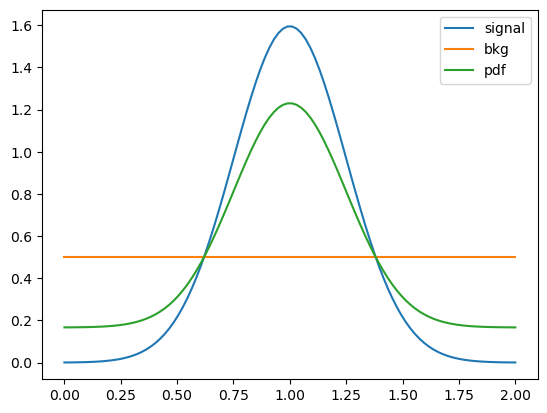

In [4]:
def pdf_x_signal(x, mu=1, sigma=1/4):
    return (4/(erf(2*np.sqrt(2))*np.sqrt(2*np.pi)))*np.exp(-0.5*((x-mu)/sigma)**2)

def pdf_x_bkg(x):
    return stats.uniform.pdf(x, 0, 2)

def pdf_x(x, signal, bkg):
    return signal/(signal+bkg)*pdf_x_signal(x)+bkg/(signal+bkg)*pdf_x_bkg(x)

x_range = np.linspace(0, 2, 100)

plt.plot(x_range, pdf_x_signal(x_range), label='signal')
plt.plot(x_range, pdf_x_bkg(x_range), label='bkg')
plt.plot(x_range, pdf_x(x_range, signal=1, bkg=1/2),label="pdf")

plt.legend()

LLH for an extended max. likelihood case is given as:

$$
\begin{align}

ln(L) = -\nu + \sum\limits_{i=1}^n ln(\nu f(x_i;\vec{\theta})) + C \quad ; \quad f(x_i;(\nu_s,\nu_b)) &= \frac{\nu_s}{\nu_s + \nu_b}f_S(x)\frac{\nu_b}{\nu_s + \nu_b}f_B(x)  \\
\text{where } \nu &= \nu_s + \nu_b

\end{align}
$$

In [5]:
def log_likelihood(signal, bkg):
    nu = signal + bkg
    llh = -nu+np.sum(np.log(nu*pdf_x(data, signal, bkg)))
    return -llh

log_likelihood(1, 1/2)

x    201.50851
dtype: float64

In [6]:
from iminuit import Minuit

m = Minuit(log_likelihood, signal=150, bkg=150)
m.limits['signal'] = (0, None)
m.limits['bkg'] = (0, None)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -2875                      │              Nfcn = 51               │
│ EDM = 4.83e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ signal │    175    │    34     │            │            │    0    │         │       │
│ 1 │ bkg    │    430    │    40     │            │            │    0    │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────┐
│        │   signal      bkg │
├────────┼───────────────────┤
│ signal │ 1.18e+03     -830 │
│    bkg │     -830 1.69e+03 │
└────────┴───────────────────┘

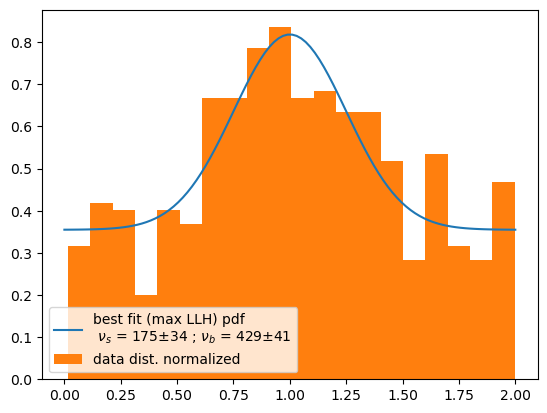

In [7]:
signal_fit, bkg_fit = m.values['signal'], m.values['bkg']
err_signal_fit, err_bkg_fit = m.errors['signal'], m.errors['bkg']
plt.plot(x_range, pdf_x(x_range, signal=signal_fit, bkg=bkg_fit),
         label=f"best fit (max LLH) pdf\n $ν_s$ = {signal_fit:.0f}$\pm${err_signal_fit:.0f} ; $ν_b$ = {bkg_fit:.0f}$\pm${err_bkg_fit:.0f}")
plt.hist(data['x'], bins=20, density=True, label='data dist. normalized')
plt.legend()
plt.show()

Looks like everything works fine with the likelihood function and the minimizer. Now, we fix $\nu_b$ and see what happens 

In [59]:
m = Minuit(log_likelihood, signal=10, bkg=420.7)
#m.limits['signal'] = (0, None)
#m.limits['bkg'] = (0, None)
m.fixed['bkg'] = True


print(m.migrad())
print(f"when bkg is fixed to 420.7, the best fit signal is ν_s =  {m.values['signal']:.0f} +- {m.errors['signal']:.0f}")
llh_max_fix_bkg = -m.fval
v_s_fix_bkg = m.values['signal']

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -2875                      │              Nfcn = 20               │
│ EDM = 2.71e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬────

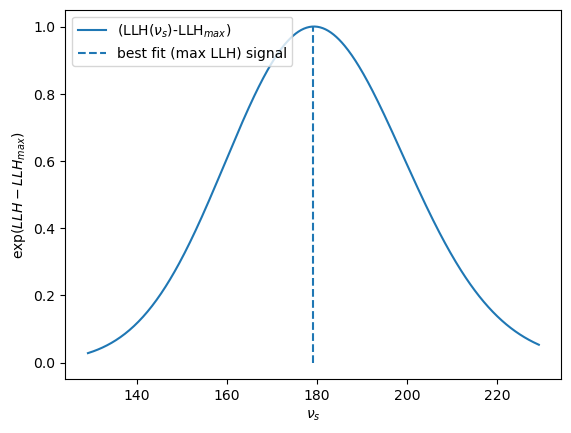

In [56]:
nu_s_space = np.linspace(v_s_fix_bkg-50, v_s_fix_bkg+50, 500)
log_likelihood_space = np.array([-log_likelihood(nu_s, 420.7) for nu_s in nu_s_space])

plt.plot(nu_s_space, np.exp(log_likelihood_space-llh_max_fix_bkg), label='(LLH($ν_s$)-LLH$_{max})$')
plt.vlines(v_s_fix_bkg, 0, 1, label='best fit (max LLH) signal', linestyles='dashed')
plt.xlabel('$ν_s$')
plt.ylabel('$\exp(LLH-LLH_{max})$')
plt.legend(loc='upper left')
plt.show()

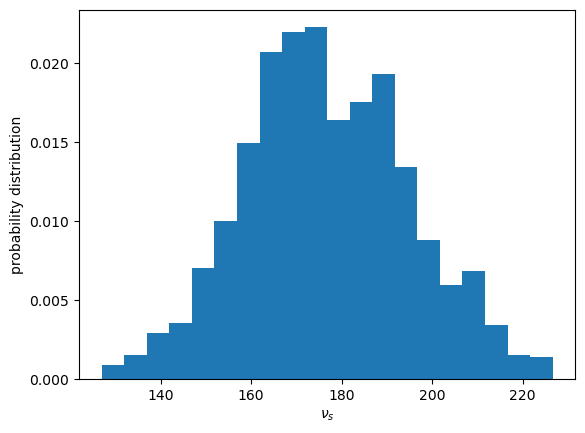

integral of the weighted values is 1.00


In [131]:
width = 50
bins = 20

random_nu_s_space = np.random.uniform(low=v_s_fix_bkg-width, high=v_s_fix_bkg+width, size=1000)
random_llh_space = np.array([-log_likelihood(nu_s, 420.7) for nu_s in random_nu_s_space])
weights = np.exp(random_llh_space-llh_max_fix_bkg).flatten()
##weighted_values = random_nu_s_space*weights # weighted values

bin_height, bin_boundary = np.histogram(random_nu_s_space, bins=bins, weights=weights)
bin_height = bin_height/np.sum(bin_height*np.diff(bin_boundary)) # normalized so integral is 1

plt.bar(bin_boundary[:-1], bin_height, width=bin_boundary[1]-bin_boundary[0], label='weighted values')
plt.xlabel('$ν_s$')
plt.ylabel('probability distribution')
plt.show()

print(f"integral of the weighted values is {np.sum(bin_height*np.diff(bin_boundary)):.2f}")

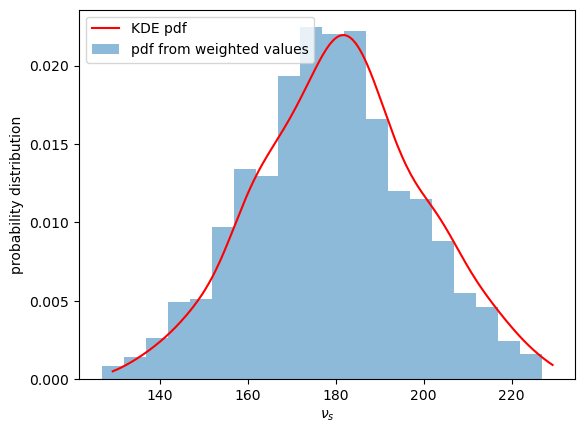

In [128]:
kde = stats.gaussian_kde(random_nu_s_space, weights=weights)
kde_values = kde.evaluate(np.sort(random_nu_s_space))

plt.plot(np.sort(random_nu_s_space), kde_values, label='KDE pdf', color='red')
plt.bar(bin_boundary[:-1], bin_height, width=bin_boundary[1]-bin_boundary[0], label='pdf from weighted values', alpha=0.5)
plt.xlabel('$ν_s$')
plt.ylabel('probability distribution')
plt.legend()
plt.show()